In [1]:
import numpy as np
import pandas as pd
import time
import scipy
import itertools
import seaborn as sns
import os
import itertools

import importlib.util
import sklearn.datasets
import matplotlib.pyplot as plt
import numpy.linalg as la

from sklearn.datasets import load_svmlight_file
from helpers import get_solution, read_logs, run_local_sgd
from np_functions import logreg_loss as single_point_loss

sns.set(style="whitegrid", context="talk", font_scale=1.2)
%load_ext autoreload
%autoreload 2

### Specify everything in config.py and then go below

##### If you are running experiments on a laptop, it's better to use small number of workers

In [2]:
!python generate_data.py

rm: cannot remove '/home/mishchk/local_sgd/data/*': No such file or directory
Number of data points: 6414
Creating chunk number 1
Creating chunk number 2
Creating chunk number 3
Creating chunk number 4
Creating chunk number 5
Creating chunk number 6
Creating chunk number 7
Creating chunk number 8
Creating chunk number 9
Creating chunk number 10
Creating chunk number 11
Creating chunk number 12
Creating chunk number 13
Creating chunk number 14
Creating chunk number 15
Creating chunk number 16
Creating chunk number 17
Creating chunk number 18
Creating chunk number 19
Creating chunk number 20


In [3]:
import config
from config import datasets_path, scripts_path, dataset, n_workers, big_regularization, scripts_path, logs_path, use_local_data

data_path = '{}/data'.format(scripts_path)
zero_based = {'mushrooms': False}

data = load_svmlight_file('{}/{}'.format(datasets_path, dataset), zero_based=zero_based.get(dataset, 'auto'))
l1 = 0 # We don't care about prox
X, y = data[0].toarray(), data[1]
if 2 in y:
    y[y == 2] = -1
n, d = X.shape
L = 0.25 * np.max(np.sum(np.square(X), axis=1))
data_info = np.load('{}/data/data_info.npy'.format(scripts_path))
Ls = data_info[4:]
l2 = np.mean(Ls) / n

In [4]:
def smooth_array(x, k=2, average=True, skip_first=0):
    if skip_first != 0:
        smoothed_part = smooth_array(x[skip_first:], k=k, average=average, skip_first=0)
        return np.array(list(x[:skip_first]) + list(smoothed_part))
    xs = [np.roll(x, i) for i in range(k)]
    for i in range(k):
        xs[i][0] = x[0]
    if average:
        return np.mean(xs, axis=0)
    return np.prod(xs, axis=0) ** (1 / k)

def logreg_loss(w, X, y, l2):
    assert l2 >= 0
    assert len(y) == X.shape[0]
    assert len(w) == X.shape[1]
    l = np.log(1 + np.exp(-X.dot(w) * y))
    m = y.shape[0]
    return np.sum(l) / m + l2/2 * la.norm(w) ** 2

def r(x, l1):
    return l1 * la.norm(x, ord = 1)

def F(w, X, y, l2, l1=0):
    assert ((y.shape[0] == X.shape[0]) & (w.shape[0] == X.shape[1]))
    assert ((l2 >= 0) & (l1 >= 0))
    return logreg_loss(w, X, y, l2) + r(w, l1)

markers = [',', 'o', '*', 'x', 'd', 'D']
mv = 20

Computing the solution using SVRG
################################################################################

0.32964556931061595

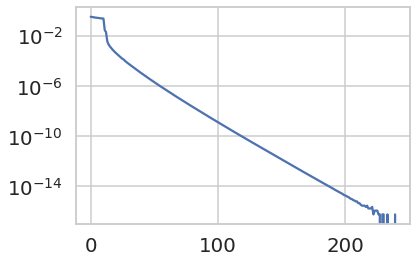

In [5]:
w_star, ws_star = get_solution(X, y, L, l2=l2, data_path=data_path, dataset=dataset, S=80,
                               big_regularization=big_regularization, recompute=True)
losses_svrg = [F(w, X, y, l2=l2, l1=l1) for w in ws_star]
plt.plot(losses_svrg - np.min(losses_svrg))
plt.yscale('log')
f_min = F(w_star, X, y, l2=l2, l1=l1)
f_min

## Run local SGD for all parameters

In [10]:
Hs = [1, 4, 16]
for H in Hs:
    lr0s = [0.5, 0.1] # lr0=a translates to a/L
    lr_decays = [0]
    batches = [1]
    local_steps = [H]
    it_max = 15000
    t_max = 120 * 1
    run_local_sgd(n_workers, scripts_path, it_max, t_max, batches, lr0s, lr_decays, local_steps, all_combinations=True)

######

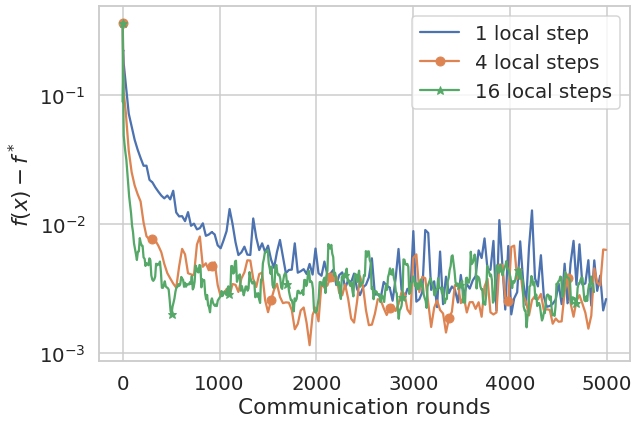

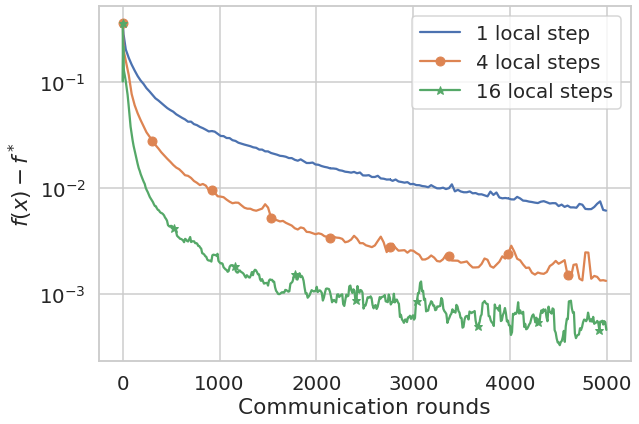

In [12]:
for lr0 in lr0s:
    plt.figure(figsize=(9, 6))
    for H, marker in zip(Hs, markers):
        local_steps = [H]
        for params in itertools.product(batches, lr_decays, local_steps):
            batch, lr_decay, local = params
            ws, loss, its, ts = read_logs(batch, lr0, lr_decay, local, big_regularization, use_local_data, logs_path)
            label = '1 local step' if H == 1 else '{} local steps'.format(local)
            idx = its < 5000
            plt.plot(its[idx], smooth_array(loss[idx], k=H // 3 + 1) - f_min, label=label, marker=marker, markevery=mv if H < 16 else 3 * mv)
#             plt.plot(its, [la.norm(w.A - w_star) for w in ws])
    plt.yscale('log')
#     plt.xlim(-500, 40000)
    plt.xlabel('Communication rounds')
    plt.ylabel('$f(x) - f^*$')
    plt.legend()
    plt.tight_layout()
    plt.savefig('../plots/local_sgd/sgd_{}_dif_H_lr{}_rounds.pdf'.format(dataset, lr0), dpi=300)

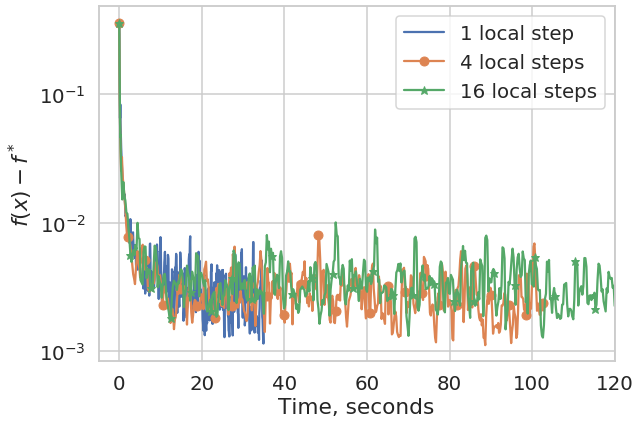

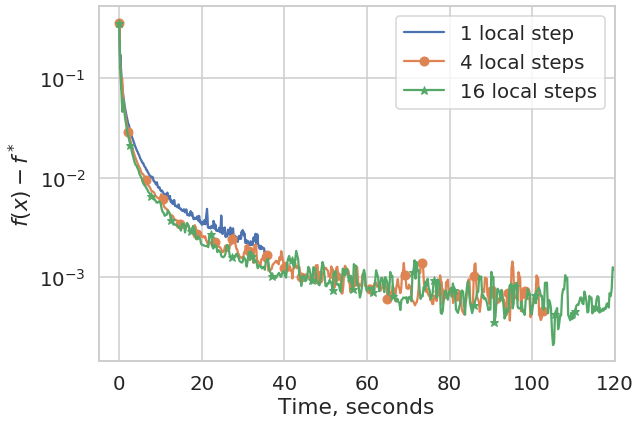

In [14]:
for lr0 in lr0s:
    plt.figure(figsize=(9, 6))
    for H, marker in zip(Hs, markers):
        local_steps = [H]
        for params in itertools.product([1], lr_decays, local_steps):
            batch, lr_decay, local = params
            ws, loss, its, ts = read_logs(batch, lr0, lr_decay, local, big_regularization, use_local_data, logs_path)
            label = '1 local step' if H == 1 else '{} local steps'.format(local)
            plt.plot(ts, smooth_array(loss, k=3, skip_first=11) - f_min, label=label, marker=marker, markevery=mv)
    plt.yscale('log')
    plt.xlabel('Time, seconds')
    plt.ylabel('$f(x) - f^*$')
    plt.xlim(-5, 120)
    plt.legend()
    plt.tight_layout()
    plt.savefig('../plots/local_sgd/sgd_{}_dif_H_lr{}_time.pdf'.format(dataset, lr0), dpi=300)

### Old results with SGD

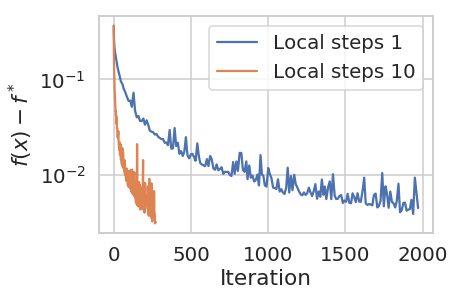

In [180]:
plt.figure(figsize=(9, 6))
for params in itertools.product(batches, lr0s, lr_decays, local_steps):
    batch, lr0, lr_decay, local = params
    ws, loss, its, ts = read_logs(batch, lr0, lr_decay, local, big_regularization, logs_path)
    plt.plot(its, loss - f_min, label='Local steps {}'.format(local))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('$f(x) - f^*$')
plt.legend()
plt.tight_layout()

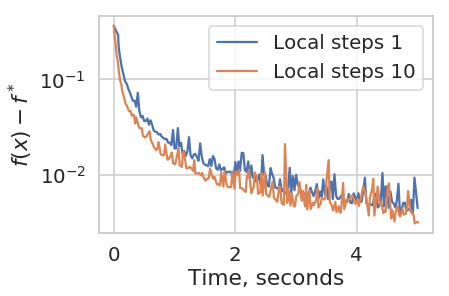

In [181]:
plt.figure(figsize=(9, 6))
for params in itertools.product(batches, lr0s, lr_decays, local_steps):
    batch, lr0, lr_decay, local = params
    ws, loss, its, ts = read_logs(batch, lr0, lr_decay, local, big_regularization, logs_path)
    plt.plot(ts, loss - f_min, label='Local steps {}'.format(local))
plt.yscale('log')
plt.xlabel('Time, seconds')
plt.ylabel('$f(x) - f^*$')
plt.legend()
plt.tight_layout()